### Check if REDMAR and ERA5 winds are consistent

I am not sure about the quality of wind data at the meteorological stations ICDN and GROM from REDMAR. So here's a quick sanity check where we compare REDMAR wind data to the ERA5 hourly reanalysis

In [143]:
from __future__ import division
import cmocean as cmo
import datetime as dt
from matplotlib.dates import date2num
import matplotlib.pyplot as plt
%matplotlib inline 
import MITgcmutils as mit
import numpy as np
import pandas as pd
from scipy import signal
import seaborn as sns
import xarray as xr
import os
import ssh_tools as ssht # my module
from scipy import signal
import sys
sys.path.append('/Users/Karina/Research/SWOT-Scripps/notebooks_SVB/')
import svb_tools as svb
import warnings
warnings.filterwarnings('ignore')

# for wavelet analysis
import pycwt as wavelet
from pycwt.helpers import find

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [13]:
def stick_plot(time, u, v, **kw):
    '''Function by Filipe Fernandes: https://ocefpaf.github.io/python4oceanographers/blog/2014/09/15/stick_plot/'''
    width = kw.pop('width', 0.002)
    headwidth = kw.pop('headwidth', 0)
    headlength = kw.pop('headlength', 0)
    headaxislength = kw.pop('headaxislength', 0)
    angles = kw.pop('angles', 'uv')
    ax = kw.pop('ax', None)
    
    if angles != 'uv':
        raise AssertionError("Stickplot angles must be 'uv' so that"
                             "if *U*==*V* the angle of the arrow on"
                             "the plot is 45 degrees CCW from the *x*-axis.")

    time, u, v = map(np.asanyarray, (time, u, v))
    if not ax:
        fig, ax = plt.subplots()
    
    q = ax.quiver(date2num(time), [[0]*len(time)], u, v,
                  angles='uv', width=width, headwidth=headwidth,
                  headlength=headlength, headaxislength=headaxislength,
                  **kw)

    ax.axes.get_yaxis().set_visible(False)
    ax.xaxis_date()
    return q

def get_dataFrame(year, station):
    col_names = ['year','month', 'day', 'hour','minute','second','ID',
                'voltage','ssh_leveltrol','ssh_burbujeador',
                'switch1','switch2', 'water_temp','ssh_radar',
                'solar_radiation','wind_dir','wind_speed',
                'air_temp','rel_humidity','atm_pressure', 'precipitation', 
                'voltage_station', 'ssh_radar_sutron']

    directory = '../REDMAR/'+station+'/'+year+'/'
    df = pd.DataFrame(columns = col_names)   
    for file in sorted([fname for fname in os.listdir(directory) if fname.endswith('.dat')]):
        filename = directory+file
        df_new = ssht.get_redmar_dataframe(filename, na_val=999)  
        df = df.append(df_new)
        continue
    return(df) 



### ERA5 file

I downloaded U and V components of wind at 5 pressure levels (1000, 900, 800, 700, 600 and 500 hPa) for all of 2016 at a similar domain as the one I have in the model.

In [14]:
filename = '../ERA5/adaptor.mars.internal-1619017350.24356-27478-13-38f5e3c8-0b99-4e39-8c95-a6e95d6a0492.nc'
ds = xr.open_dataset(filename)

Who's there?

In [15]:
ds

<xarray.Dataset>
Dimensions:    (latitude: 33, level: 6, longitude: 29, time: 8784)
Coordinates:
  * longitude  (longitude) float32 -121.0 -120.75 -120.5 ... -114.25 -114.0
  * latitude   (latitude) float32 35.0 34.75 34.5 34.25 ... 27.5 27.25 27.0
  * level      (level) int32 500 600 700 800 900 1000
  * time       (time) datetime64[ns] 2016-01-01 ... 2016-12-31T23:00:00
Data variables:
    u          (time, level, latitude, longitude) float32 ...
    v          (time, level, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2021-04-21 16:27:13 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

In [17]:
# Load coastline from model output
outdir = '/Volumes/KYUUBI/SVB/05_448x512x100/04_feb_TSref/mnc_test_0001/'
bat = mit.mnc.mnc_files(outdir+'grid.t*.nc', layout='exch2')
depth = bat.variables['Depth'][:]
lat = bat.variables['YC'][:,0]
lon = bat.variables['XC'][0,:]

Text(0.5, 1.0, '2016-01-08T02:00:00.000000000')

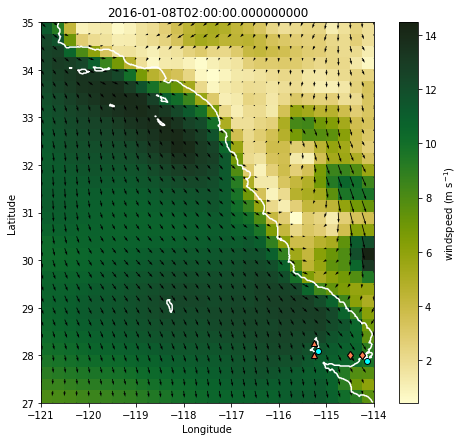

In [18]:
tind = 170 # around Jan 8
zind = 5  # 1000 hPa
spd = np.sqrt(ds.u[tind,zind,...]**2 + ds.v[tind,zind,...]**2)

xa1 = 23#22
xa2 = 23#23
ya1 = 27#25
ya2 = 28#26

xb1 = 26#26
xb2 = 27#27
yb1 = 28#27
yb2 = 28#28

# Plot snapshot
fig, ax = plt.subplots(1,1, figsize=(9,7))
pc = ax.pcolormesh(ds.longitude,ds.latitude,  spd, cmap=cmo.cm.speed)
plt.colorbar(pc, ax=ax, label=r'windspeed (m s$^{-1}$)')
ax.quiver(ds.longitude,ds.latitude,ds.u[0,zind,...],ds.v[0,zind,...])
ax.contour(lon-360, lat, depth, levels=[-2,0], colors='w')
lon_ICDN = [ds.longitude[xa1], ds.longitude[xa1], ds.longitude[xa2], ds.longitude[xa2]]
lat_ICDN = [ds.latitude[ya1], ds.latitude[ya2],ds.latitude[ya1], ds.latitude[ya2]]
lon_GROM = [ds.longitude[xb1],ds.longitude[xb1],ds.longitude[xb2],ds.longitude[xb2]]
lat_GROM = [ds.latitude[yb1],ds.latitude[yb2],ds.latitude[yb1],ds.latitude[yb2]]
ax.plot(lon_ICDN, lat_ICDN, '^', color='coral', markeredgecolor='k')
ax.plot(lon_GROM, lat_GROM, 'd', color='coral', markeredgecolor='k')

ax.plot(-115-(10.992/60),28+(5.760/60), 'o', color='cyan' ,markeredgecolor='k')
ax.plot(-114-(9/60),27+(53/60), 'o', color='cyan',markeredgecolor='k' )
ax.set_aspect(1)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title(str(ds.time[tind].data))

Average grid cells to compare to wind stations from REDMAR: diamonds for GROM, triangles for ICDN.

Hourly timeseries for 2016 at 1000 hPa layer:

Text(0, 0.5, 'Windspeed (m s$^{-1}$)')

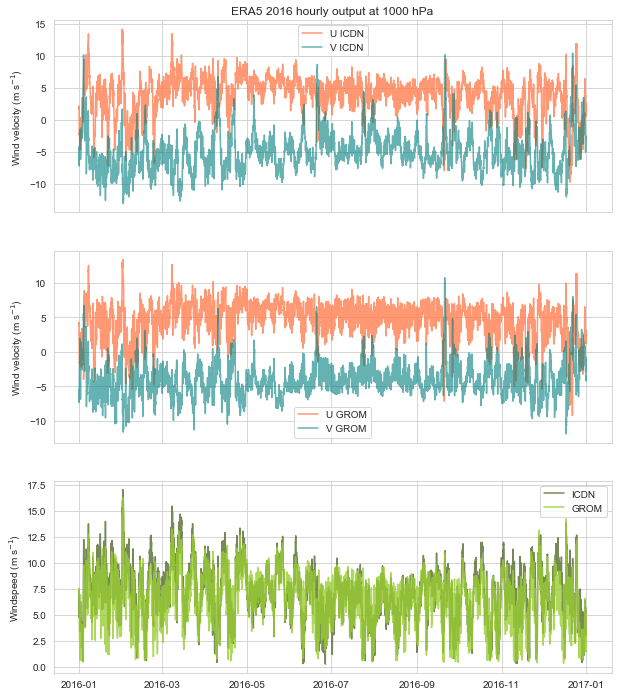

In [19]:

# Timeseries of mean U, V and speed at equivalent ICDN and GROM 
U_ICDN = (ds.u[:,zind,ya1:ya2+1,xa1:xa2+1].mean(dim='latitude')).mean(dim='longitude')
V_ICDN = (ds.v[:,zind,ya1:ya2+1,xa1:xa2+1].mean(dim='latitude')).mean(dim='longitude')
speed_ICDN = np.sqrt((ds.u[:,zind,ya1:ya2+1,xa1:xa2+1]**2+ds.v[:,zind,ya1:ya2+1,xa1:xa2+1]**2))
SPD_ICDN = (speed_ICDN.mean(dim='latitude')).mean(dim='longitude')

U_GROM = (ds.u[:,zind,yb1:yb2+1,xb1:xb2+1].mean(dim='latitude')).mean(dim='longitude')
V_GROM = (ds.v[:,zind,yb1:yb2+1,xb1:xb2+1].mean(dim='latitude')).mean(dim='longitude')
speed_GROM = np.sqrt((ds.u[:,zind,yb1:yb2+1,xb1:xb2+1]**2+ds.v[:,zind,yb1:yb2+1,xb1:xb2+1]**2))
SPD_GROM = (speed_GROM.mean(dim='latitude')).mean(dim='longitude')

# Plot timeseries
sns.set_style('whitegrid')
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(10,12), sharex=True,)
ax1.plot(ds.time, U_ICDN, label='U ICDN', color='coral', alpha=0.8)
ax1.plot(ds.time, V_ICDN, label='V ICDN', color='teal', alpha=0.6)
ax1.set_ylabel(r'Wind velocity (m s$^{-1}$)')
ax1.legend()
ax1.set_title('ERA5 2016 hourly output at 1000 hPa')

ax2.plot(ds.time, U_GROM, label='U GROM', color='coral', alpha=0.8)
ax2.plot(ds.time, V_GROM, label='V GROM', color='teal', alpha=0.6)
ax2.set_ylabel(r'Wind velocity (m s$^{-1}$)')
ax2.legend()

ax3.plot(ds.time, SPD_ICDN, color='darkolivegreen', alpha=0.8, label='ICDN')
ax3.plot(ds.time, SPD_GROM, color='yellowgreen', alpha=0.8, label='GROM')
ax3.legend()
ax3.set_ylabel(r'Windspeed (m s$^{-1}$)')


**Stickplots:**

If there were any doubts, wind indeed blows mosty towards the southeast most of the time in both stations...

Text(0.5, 1.0, 'ERA5 GROM 2016')

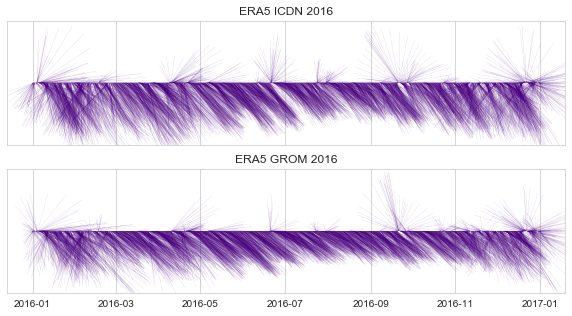

In [20]:
dt = 1
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,5), sharex=True, sharey=True)
q1 = stick_plot(ds.time[::dt], U_ICDN[::dt], V_ICDN[::dt], ax=ax1, width=0.0001, scale=100, color='indigo')
ax1.set_title('ERA5 ICDN 2016')
q2 = stick_plot(ds.time[::dt], U_GROM[::dt], V_GROM[::dt], ax=ax2, width=0.0001, scale=100, color='indigo')
ax2.set_title('ERA5 GROM 2016')

### REDMAR wind data

In [21]:
year = '2016'
df_ICDN = get_dataFrame(year, 'ICDN')
df_GROM = get_dataFrame(year, 'GROM')   

In [22]:
# # Filter using running mean to get 1 hr records      
# dir_GROM = ssht.filter_timeseries(df_GROM['wind_dir'].values, winlen=29, method='box')
# dir_ICDN = ssht.filter_timeseries(df_ICDN['wind_dir'].values, winlen=29, method='box')
# spd_GROM = ssht.filter_timeseries(df_GROM['wind_speed'].values/3.6, winlen=29, method='box') # units at GROM are km/h, so we have to convert to m/s
# spd_ICDN = ssht.filter_timeseries(df_ICDN['wind_speed'].values, winlen=29, method='box')

In [23]:
dir_GROM = df_GROM['wind_dir'] 
dir_ICDN = df_ICDN['wind_dir']
spd_GROM = df_GROM['wind_speed']/3.6 # units at GROM are km/h, so we have to convert to m/s
spd_ICDN = df_ICDN['wind_speed']

In [24]:
u_GROM = (spd_GROM[:])*np.cos((np.pi*dir_GROM[:].astype(np.float))/180)
v_GROM = (spd_GROM[:])*np.sin((np.pi*dir_GROM[:].astype(np.float))/180)

u_ICDN = spd_ICDN[:]*np.cos((np.pi*dir_ICDN[:].astype(np.float))/180)
v_ICDN = spd_ICDN[:]*np.sin((np.pi*dir_ICDN[:].astype(np.float))/180)

Text(0, 0.5, 'Windspeed (m s$^{-1}$)')

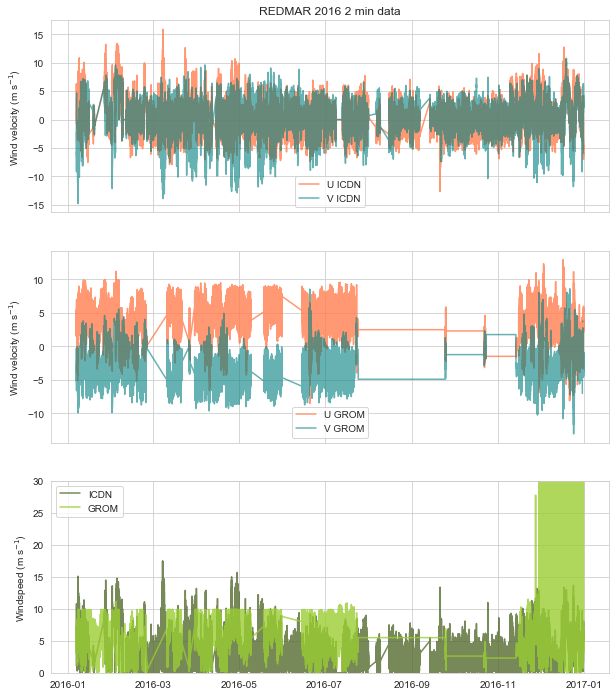

In [25]:
# Plot timeseries
sns.set_style('whitegrid')
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(10,12), sharex=True,)
ax1.plot(u_ICDN.index, u_ICDN, label='U ICDN', color='coral', alpha=0.8)
ax1.plot(v_ICDN.index, v_ICDN, label='V ICDN', color='teal', alpha=0.6)
ax1.set_ylabel(r'Wind velocity (m s$^{-1}$)')
ax1.legend()
ax1.set_title('REDMAR 2016 2 min data')

ax2.plot(u_GROM.index, u_GROM, label='U GROM', color='coral', alpha=0.8)
ax2.plot(v_GROM.index, v_GROM, label='V GROM', color='teal', alpha=0.6)
ax2.set_ylabel(r'Wind velocity (m s$^{-1}$)')
ax2.legend()

ax3.plot(spd_ICDN.index, spd_ICDN, color='darkolivegreen', alpha=0.8, label='ICDN')
ax3.plot(spd_GROM.index, spd_GROM, color='yellowgreen', alpha=0.8, label='GROM')
ax3.legend()
ax3.set_ylim(0, 30)
ax3.set_ylabel(r'Windspeed (m s$^{-1}$)')


Text(0.5, 1.0, 'REDMAR GROM 2016')

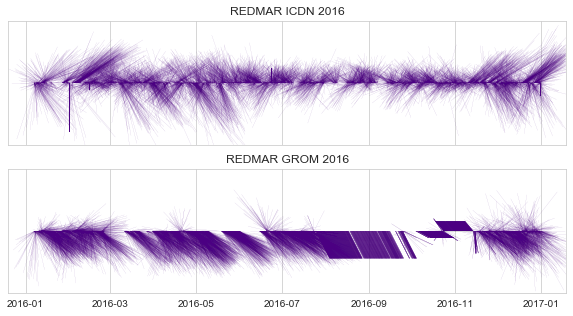

In [26]:
dt = 30
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,5), sharex=True, sharey=True)
q1 = stick_plot(v_ICDN[::dt].index, u_ICDN[::dt], v_ICDN[::dt], ax=ax1, width=0.0001, scale=100, color='indigo')
ax1.set_title('REDMAR ICDN 2016')
q2 = stick_plot(v_GROM[::dt].index, u_GROM[::dt], v_GROM[::dt], ax=ax2, width=0.0001, scale=100, color='indigo')
ax2.set_title('REDMAR GROM 2016')

### Comparison

Text(0.5, 1.0, 'V velocity at GROM')

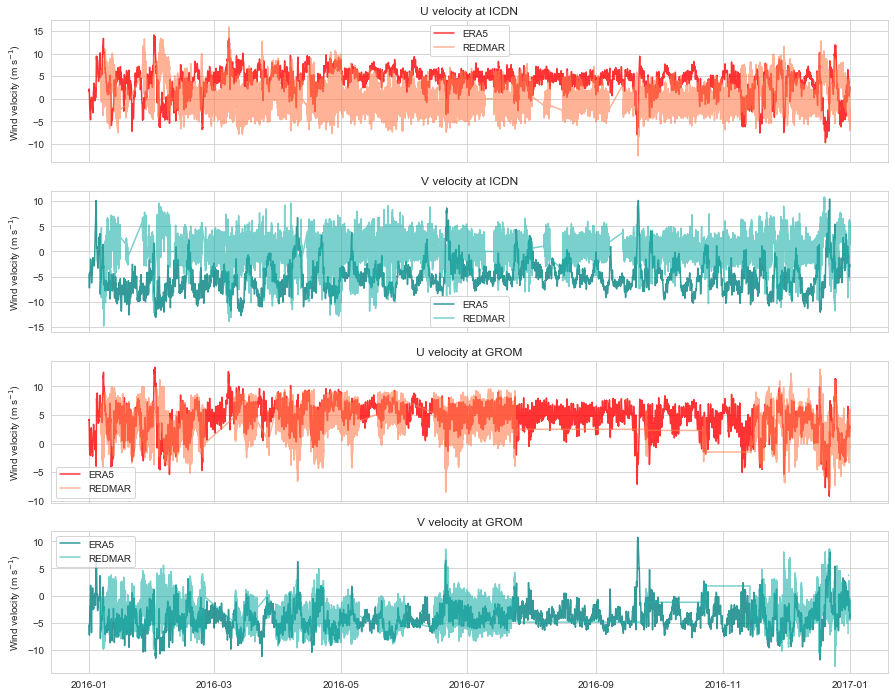

In [29]:
# Plot timeseries
sns.set_style('whitegrid')
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize=(15,12), sharex=True)

ax1.plot(ds.time, U_ICDN, label='ERA5', color='red', alpha=0.8)
ax1.plot(u_ICDN.index, u_ICDN, label='REDMAR', color='coral', alpha=0.6)
ax1.set_ylabel(r'Wind velocity (m s$^{-1}$)')
ax1.legend()
ax1.set_title('U velocity at ICDN')

ax2.plot(ds.time, V_ICDN, label='ERA5', color='teal', alpha=0.8)
ax2.plot(v_ICDN.index, v_ICDN, label='REDMAR', color='lightseagreen', alpha=0.6)
ax2.set_ylabel(r'Wind velocity (m s$^{-1}$)')
ax2.legend()
ax2.set_title('V velocity at ICDN')

ax3.plot(ds.time, U_GROM, label='ERA5', color='red', alpha=0.8)
ax3.plot(u_GROM.index, u_GROM, label='REDMAR', color='coral', alpha=0.6)
ax3.set_ylabel(r'Wind velocity (m s$^{-1}$)')
ax3.legend()
ax3.set_title('U velocity at GROM')

ax4.plot(ds.time, V_GROM, label='ERA5', color='teal', alpha=0.8)
ax4.plot(v_GROM.index, v_GROM, label='REDMAR', color='lightseagreen', alpha=0.6)
ax4.set_ylabel(r'Wind velocity (m s$^{-1}$)')
ax4.legend()
ax4.set_title('V velocity at GROM')


### Frequency Spectra

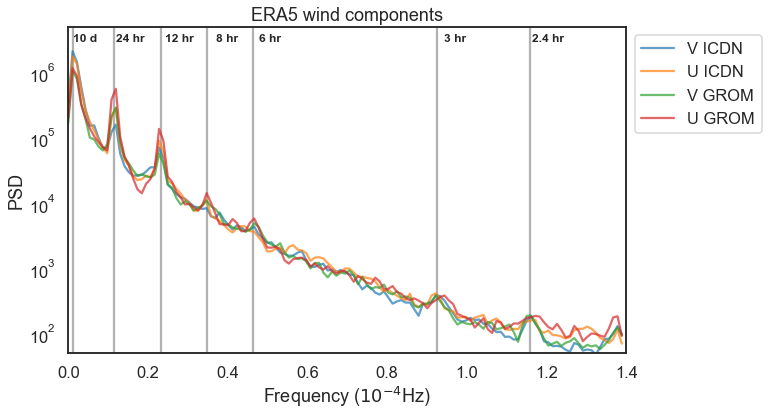

In [140]:
sns.set_context('talk')
sns.set_style('white')
samp_freq = 1/3600 # 1 hr data
fig,(ax) = plt.subplots(1,1,figsize=(10,6))

# Useful freq to period indicators
ax.axvline(1e4/(24*3600), color='k', alpha=0.3, linestyle='-') # 4.8 hr - max PSD - Kelvin wave
ax.axvline(1e4/(12.*3600), color='k', alpha=0.3, linestyle='-') # 3 hr - cutoff period
ax.axvline(1e4/(8*3600), color='k', alpha=0.3, linestyle='-') # 2.4 hr 
ax.axvline(1e4/(6*3600), color='k', alpha=0.3, linestyle='-') # 2.4 hr 
ax.axvline(1e4/(3*3600), color='k', alpha=0.3, linestyle='-') # 1.2 hr 
ax.axvline(1e4/(2.4*3600), color='k', alpha=0.3, linestyle='-') # 0.5 hr 
ax.axvline(1e4/(240*3600), color='k', alpha=0.3, linestyle='-') # 24 hr 
ax.text(1e4/((240-20)*3600),3E6,'10 d', fontweight='bold',fontsize=12)
ax.text(1e4/((24-1)*3600),3E6,'24 hr', fontweight='bold',fontsize=12)
ax.text(1e4/((12-0.5)*3600),3E6,'12 hr', fontweight='bold',fontsize=12)
ax.text(1e4/((8-0.5)*3600),3E6,'8 hr', fontweight='bold',fontsize=12)
ax.text(1e4/((6-0.2)*3600),3E6,'6 hr', fontweight='bold',fontsize=12)
ax.text(1e4/((3-0.05)*3600),3E6,'3 hr', fontweight='bold',fontsize=12) 
ax.text(1e4/((2.4-0.01)*3600),3E6,'2.4 hr', fontweight='bold',fontsize=12)

freq_per, Pxx_den_per = signal.welch(V_ICDN, samp_freq, detrend='constant')
ax.semilogy(1E4*freq_per, Pxx_den_per,'-', alpha=0.7, label='V ICDN')

freq_per2, Pxx_den_per2 = signal.welch(U_ICDN, samp_freq, detrend='constant')
ax.semilogy(1E4*freq_per2, Pxx_den_per2,'-', alpha=0.7, label='U ICDN')

freq_per3, Pxx_den_per3 = signal.welch(V_GROM, samp_freq, detrend='constant')
ax.semilogy(1E4*freq_per3, Pxx_den_per3,'-', alpha=0.7, label='V GROM')

freq_per4, Pxx_den_per4 = signal.welch(U_GROM, samp_freq, detrend='constant')
ax.semilogy(1E4*freq_per4, Pxx_den_per4,'-', alpha=0.7, label='U GROM')

ax.set_ylabel('PSD')
ax.set_xlim(0,1.4)
ax.set_ylim(5E1,5E6)
ax.set_xlabel('Frequency ($10^{-4}$Hz)')
ax.set_title('ERA5 wind components')
ax.legend(ncol=1, bbox_to_anchor=(1,1))    